In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r
import scipy.io as sio
import math
import sklearn.decomposition
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

## Helper functions

In [2]:
def load_data(path, col_name):
    """
    Load input data from matlab file.
    
    Parameters
    ----------
    path : String
        The relative path of matlab file    
    col_name : String
        Label of the input data within the
        file
    
    Returns
    -------
    Pandas DataFrame
        Contains the input data
    """
    data = sio.loadmat(path)
    data = pd.DataFrame(data['Y'])
    
    return data

def generate_centers(X, k):
    """
    Chooses k input data points at random from
    the given data
    
    Parameters
    ----------
    X : N x D matrix
        where N is the total number of input data
        points and D is the number of features
    k : Integer
        Number of centers to be generated
    
    Returns
    -------
    List
        Containing k data points
    """
    
    # Generate a list of k random indices
    indices = np.random.randint(0, X.shape[0], k)
    
    # Extract the rows corresponding to the above
    # indices and return
    return X[indices]

def compute_distance(x, y):
    """
    Computes the euclidean distance between
    two points x and y
    
    Parameters
    ----------
    x : 1 x D matrix
        The first point
    y : 1 x D matrix
        The second point
    
    Returns
    -------
    Double
        The euclidean distance between the two
        points
    """
    z = np.power((x - y), 2)
    z = np.sum(z)
    
    #return np.power(z, 0.5)
    return z

def compute_weight(x, y, v):
    """
    Computes the euclidean distance between
    two points x and y
    
    Parameters
    ----------
    x : 1 x D matrix
        The first point
    y : 1 x D matrix
        The second point
    v : Double
        The variance
    
    Returns
    -------
    Double
        The weight between these two points
        calculated using the gaussian kernel
        function
    """
    z = abs(np.linalg.norm(x - y))
    z = np.sum(z) /  v
    
    #return np.power(z, 0.5)
    return math.exp(-z)

def plot_data(X, data_centers):
    
    # Add cluster centers to data points
    C = np.matrix(data_centers).T
    X = np.hstack((X, C))
    data = pd.DataFrame(X, columns=['x1', 'x2', 'c'])
    
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Draw the plots
    ax.scatter(data.x1, data.x2, label='Data', c=data.c * 10)
    
    # Set extra properties for readability
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('x1 vs. x2')

def plot_mse(M):
    iters = [(i + 1) for i in range(len(M))]
    plt.plot(iters, M, 'k-')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('MSE')
    #plt.xscale('log')
    #plt.yscale('log')

def compute_mse(clustered_data, centers):
    """
    Calculates the mean squared error for the
    clustering scheme specified
    
    Parameters
    ----------
    clustered_data : List<List<(1 x D)>>
        Data points grouped by their cluster
        centers
    centers : k x D matrix
        The k cluster centers
    
    Returns
    -------
    Double
        The mean squared error
    """
    
    mse = 0
    
    for i in range(0, len(centers)):
        
        # Get the cluster center and points in this cluster
        curr_center = np.matrix(centers[i])
        curr_cluster = clustered_data[i]
        
        # Calculate the squared error for each point
        for j in range(0, len(curr_cluster)):
            curr_point = np.matrix(curr_cluster[j])
            mse += compute_distance(curr_point, curr_center)
    
    return mse

## PCA

In [3]:
def pca(X, d):
    """
    Performs Principal Component Analysis on the
    given data to reduce its dimensions.
    
    Parameters
    ----------
    X : N x D matrix
        where N is the number of data points and
        D is the ambient dimension
    d : Integer
        Dimensionality of the low-dimensional
        representation
    
    Returns
    -------
    D x d matrix
        The basis of the low-dimensional subspace
    1 x d matrix
        The mean of the subspace
    d x N matrix
        The low dimensional representation of the
        input data
    """

    # Do mean normalization
    M_X = np.sum(X, axis = 0)
    M_X = M_X / X.shape[0]
    X = X - M_X

    # Find the correlation matrix
    C = (X.T * X) / X.shape[0]

    # Do eigenvalue decomposition and get hold of 
    # the eigenvalues (D) and eigenvectors (V) of 
    # covariance matrix
    D, V = np.linalg.eig(C)

    # Extract the top-d eigenvectors
    V = V[:, 0:d]
    
    # Represent data in this basis
    Y = X * V
    
    # Calculate the mean of low-dimensional space
    M_Y = np.sum(Y, axis=0) / Y.shape[0]
    
    return V.T, M_Y, Y.T

## K-means

In [4]:
def k_means(X, k, r):
    """
    Executes the K-means algorithm to cluster the
    data into k clusters. The underlying algorithm
    uses multiple random initializations to circle
    in on the best possible clustering scheme.
    
    Parameters
    ----------
    X : N x D matrix
        where N is the number of data points and
        D is the ambient dimension
    k : Integer
        The desired number of clusters
    r : Integer
        The desired number of repititions with
        different random initializations
    
    Returns
    -------
    1 x N matrix
        which contains the best clustering scheme
    """
    
    A = []
    C = []
    M = []
    
    for i in range(r):
        new_cluster_assignment, centers, mse = cluster_data(X, k)
        A.append(new_cluster_assignment)
        C.append(centers)
        M.append(mse)
    
    lowest_mse = min(M)
    best_run = M.index(lowest_mse)
    best_centers = C[best_run]
    best_cluster_assignment = A[best_run]
    
    #U, mean, Y = pca(X, 2)    
    #plot_data(Y[0:2, :].T, new_cluster_assignment)
    
    return lowest_mse, best_centers, best_cluster_assignment

def cluster_data(X, k):
    """
    Finds the best clustering scheme for the
    specified parameters
    
    Parameters
    ----------
    X : N x D matrix
        The input data
    k : Integer
        The number of cluster centers
    
    Returns
    -------
    List<Integer>
        The indices of cluster centers assigned
        to each data point
    List<(1 x D)>
        The cluster centers
    Double
        The mean squared error
    """
    centers = []  # Stores the centers
    mse = 0
    
    # Randomly choose k points from the data
    # as centers
    centers = generate_centers(X, k)
    
    old_cluster_assignment = [-1 for i in range(X.shape[0])]
    new_cluster_assignment = []
    
    while True:
        new_cluster_assignment, clusters, centers = update_cluster_centers(X, centers)
        if (np.array_equal(old_cluster_assignment, new_cluster_assignment)):
            mse = compute_mse(clusters, centers)
            break
        else:
            old_cluster_assignment = new_cluster_assignment
    
    return new_cluster_assignment, centers, mse

def update_cluster_centers(X, centers):
    """
    Clusters the data points to their nearest
    cluster centers and re-aligns the cluster
    centers to the mean of these new clusters
    
    Parameters
    ----------
    X : N x D matrix
        The input data points
    centers : k x D matrix
        The centers to which data points need
        to be clustered
    
    Returns
    -------
    List<Integer>
        Index of cluster center for each point
    List<List<(1 x D)>>
        The points clustered to their new
        centers
    List<(1 x D)>
        The updated cluster centers
    """
    
    k = len(centers)
    N = X.shape[0]
    cluster_assignment = []  # Stores the index of the center for each point
    
    # Initialize variable to store points by clusters
    clusters = []
    for i in range(0, k):
        clusters.append([])
    
    # Assign each point to nearest cluster center
    for i in range(0, N):
        curr_x = X[i]
        
        # Initialize
        closest_center = -1
        dist_to_center = -1
        
        for j in range(0, k):
            curr_center = centers[j]
            curr_dist = compute_distance(curr_x, curr_center)
            
            if (dist_to_center == -1 or 
                dist_to_center > curr_dist):
                
                # Re-assign this point to the
                # current cluster center
                
                closest_center = j
                dist_to_center = curr_dist
        
        # Assign this point to its new cluster
        # center
        cluster_assignment.append(closest_center)
        clusters[closest_center].append(curr_x)
    
    # Re-initialize cluster centers
    for i in range(0, k):
        member_count = len(clusters[i])
        new_center = np.sum(clusters[i], axis = 0) / member_count
        centers[i] = new_center
    
    return cluster_assignment, clusters, centers

## Spectral Clustering

In [5]:
def spectral(W, k):
    """
    Executes the Spectral Clustering algorithm to
    cluster the data into k clusters
    
    Parameters
    ----------
    W : N x N matrix
        where N is the number of data points
        The similarity matrix
    k : Integer
        The desired number of clusters
    
    Returns
    -------
    1 x N matrix
        which contains the best clustering scheme
    """
    

In [6]:
data = load_data("HW3_Data/dataset2.mat", 'Y')
X = np.matrix(data.values)


"""
u = pd.DataFrame(Y[1:3, :].T, columns=['X', 'Y'])
u.plot(kind="scatter", x='X', y='Y', figsize=(12, 8))
"""

'\nu = pd.DataFrame(Y[1:3, :].T, columns=[\'X\', \'Y\'])\nu.plot(kind="scatter", x=\'X\', y=\'Y\', figsize=(12, 8))\n'

In [7]:
pca = sklearn.decomposition.PCA(n_components=2)

X = X.T

data = pd.DataFrame(X)
pca.fit(data)
pca_subsetted_data = pca.transform(data)

new_data = pd.DataFrame(pca_subsetted_data, columns=['x1', 'x2'])
new_data.describe()

,x1,x2
count,2.000000e+02,2.000000e+02
mean,-7.771561e-18,-2.220446e-18
std,6.956606e-01,6.022878e-01
min,-1.208160e+00,-1.205534e+00
25%,-4.535325e-01,-4.307932e-01
50%,3.210297e-02,-2.564871e-02
75%,4.993766e-01,4.331736e-01
max,1.336805e+00,1.229361e+00


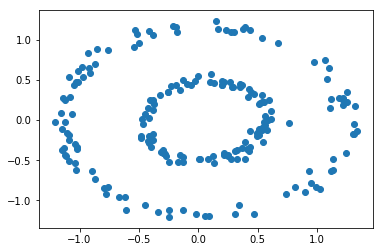

In [8]:
plt.scatter(new_data.x1, new_data.x2)
#plot_data(pca_subsetted_data, best_cluster_assignment)

In [9]:
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

new_data.var()

x1    0.483944
x2    0.362751
dtype: float64

In [10]:
#print(indices)

# Generate similarity matrix W
W = []
D = []
N = X.shape[0]
for i in range(N):
    W.append([0 for i in range(N)])
    D.append([0 for i in range(N)])

for i in range(N):
    curr_point = X[i]
    neighbors = indices[i]
    for j in range(len(neighbors)):
        curr_neighbor_index = neighbors[j]
        curr_neighbor = X[curr_neighbor_index]
        W[i][curr_neighbor_index] = compute_weight(curr_point, curr_neighbor, 0.01)

for i in range(N):
    W[i][i] = 0

for i in range(N):
    curr_degree = 0
    neighbors = indices[i]
    for j in range(len(neighbors)):
        curr_neighbor_index = neighbors[j]
        curr_degree += W[i][curr_neighbor_index]
    D[i][i] = curr_degree

In [11]:
D = np.matrix(D)
W = np.matrix(W)
L = D - W

In [12]:
E, V = np.linalg.eig(L)

In [13]:
print(E)
print(E.argsort())

[  4.15130318e-15 +0.00000000e+00j   4.43783921e-15 +0.00000000e+00j
   2.90512956e-16 +0.00000000e+00j   8.06417144e-16 +0.00000000e+00j
   4.72429745e-15 +0.00000000e+00j   4.79949726e-16 +0.00000000e+00j
   7.00949394e-18 +0.00000000e+00j   4.95452828e-15 +0.00000000e+00j
   2.93476355e-13 +0.00000000e+00j   5.23615707e-16 +0.00000000e+00j
   7.11534451e-15 +0.00000000e+00j   5.57387552e-17 +0.00000000e+00j
   3.66650378e-18 +0.00000000e+00j   1.11544836e-15 +0.00000000e+00j
   1.02681009e-15 +0.00000000e+00j   2.51194827e-13 +0.00000000e+00j
   3.50395806e-17 +0.00000000e+00j   2.39964781e-16 +0.00000000e+00j
   1.95406080e-16 +0.00000000e+00j   7.90367617e-19 +0.00000000e+00j
   5.80672847e-20 +0.00000000e+00j   1.17301769e-17 +0.00000000e+00j
   4.25838971e-18 +0.00000000e+00j   1.52449273e-21 +0.00000000e+00j
   2.60584782e-19 +0.00000000e+00j   6.42582690e-20 +0.00000000e+00j
   9.28325778e-21 +0.00000000e+00j   3.55692463e-19 +0.00000000e+00j
   4.23286934e-16 +0.00000000e+00j

In [14]:
V1 = V[39].getA1()
V2 = V[40].getA1()
top_V = [V1, V2]
top_V = np.matrix([V1, V2]).T
print(top_V.shape)

(200, 2)


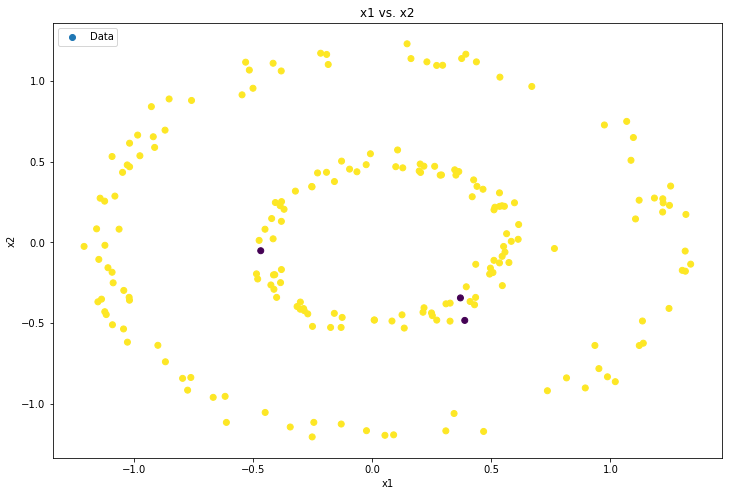

In [15]:
mse, centers, cluster_assignments = k_means(top_V, 2, 5)

plot_data(np.matrix(new_data), cluster_assignments)

In [16]:
print(cluster_assignments)

[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
